This notebook has porpuse of showing the dataset that we used, alongside the prediction of the different cosmological models that we analyzed.

In [2]:
import time
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.constants import c as c_light #meters/seconds
from scipy.integrate import cumtrapz as cumtrapz
from scipy.integrate import simps, solve_ivp
from scipy.constants import c as c_light #meters/seconds
from scipy.stats.distributions import chi2 as chi2_dist
c_light_km = c_light/1000 #kilometers/seconds

import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_datos_global = os.path.dirname(path_git)
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))
from supernovae import aparent_magnitude_th, chi2_supernovae
from constants import OMEGA_R_0, LAMBDA, L, KAPPA
from solve_sys import Hubble_th as Hubble_th
from chi_square import all_parameters

Here we define the plotting function.

In [3]:

def F_H(H, params, model):     
    lamb, L, beta, L_bar, r, s = params # L and L_bar have to be in units of H0^{-1}
    if model == 'GILA':
        lamb = 0; p = 3; q = 1
        FH = H**2 - beta * H**(2*r) * L_bar**(2*(r-1)) * np.exp(-beta*(L_bar*H)**(2*s)) #\
                  #+ lamb * H**(2*p) * L**(2*(p-1))     * np.exp(lamb*(L*H)**(2*q))

    elif model == 'BETA':
        lamb = 0; p = 1; q = 2; r = 1
        FH = H**2 - beta * H**2                        * np.exp(-beta*(L_bar*H)**(2*s)) #\
                  #+ lamb * H**(2*p) * L**(2*(p-1))     * np.exp(lamb*(L*H)**(2*q))

    return FH


def F_H_prime(H, params, model):
    lamb, L, beta, L_bar, r, s = params # L and L_bar have to be in units of H0^{-1}
   
    if model == 'GILA':
        lamb = 0; p = 3; q = 1
        aux = beta * np.exp(-beta*(L_bar*H)**(2*s)) * (L_bar*H)**(2*(r-1)) * (-r + s * beta * (L_bar*H)**(2*s)) #+\
              #lamb * np.exp(lamb*(L*H)**(2*q))      * (L*H)**(2*(p-1))     * (p  + q * lamb * (L*H)**(2*q))

    elif model == 'BETA':
        lamb = 0; p = 1; q = 2; r = 1
        aux = beta * np.exp(-beta*(L_bar*H)**(2*s))                        * (-1 + s * beta * (L_bar*H)**(2*s)) #+\
              #lamb * np.exp(lamb*(L*H)**(2*q))      * (L*H)**(2*(p-1)) * (p  + q * lamb * (L*H)**(2*q))

    FH_prime = 2 * H * (1 + aux) 
    return FH_prime


def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'LCDM'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    [LAMBDA, L, b, L_bar, H_0, r, s, model] = params_ode #Here L and L_bar are in units of H0^{-1}

    F_H0 = F_H(H_0, [LAMBDA, L, b, L_bar, r, s], model)

    omega_m_0 = F_H0 /(100**2) - OMEGA_R_0

    rho_m_0 = 100**2 * omega_m_0 / KAPPA
    rho_r_0 = 100**2 * OMEGA_R_0 / KAPPA
    
    rho_r = rho_r_0 * (1+z)**4
    rho_m = rho_m_0 * (1+z)**3
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * KAPPA * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [LAMBDA, L, b, L_bar, r, s], model))     
    #print(s)
    return s


def integrator_GILA(physical_params, model, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    #L_bar, b, H0 = physical_params
    L_bar, b, H0, r, s = physical_params
    
    #Cambiar si pasamos de logspace a linspace!
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    
    #ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, model]
    ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, r, s, model]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

def chi2_without_cov(teo, data, errors_cuad):
    '''
    Calculate chi square assuming no correlation.

    teo (array): Theoretical prediction of the model.
    data (array): Observational data to compare with the model.
    errors_cuad (array): The square of the errors of the data.

    '''

    chi2 = np.sum((data-teo)**2/errors_cuad)
    return chi2

def params_to_chi2(theta, model, dataset_CC=None,dataset_SN_plus_shoes=None,
                   num_z_points=int(10**5)):

    #chi2_SN = 0
    #chi2_CC = 0
    
    [Mabs, L_bar, b, H_0, r, s] = theta
    physical_params = [L_bar, b, H_0, r, s]
    try:
        zs_model, Hs_model = integrator_GILA(physical_params, model=model, num_z_points=num_z_points,
                                            initial_z=0, final_z=10)
    except Exception as e:
        # If integration fails, reject the step
        return -np.inf

    Hs_interp = interp1d(zs_model, Hs_model)

    int_inv_Hs = cumtrapz(Hs_model**(-1), zs_model, initial=0)
    int_inv_Hs_interp = interp1d(zs_model, int_inv_Hs)

    if dataset_CC != None:
        z_data, H_data, dH = dataset_CC #Import the data
        H_teo = Hs_interp(z_data)
        chi2_CC = chi2_without_cov(H_teo, H_data, dH**2)

    if dataset_SN_plus_shoes != None:
        zhd, zhel, mb, mu_shoes, Cinv, is_cal = dataset_SN_plus_shoes #Import the data
        muobs = mb - Mabs
        muth_num = aparent_magnitude_th(int_inv_Hs_interp, zhd, zhel) #Numeric prediction of mu
        muth = muth_num*(-is_cal + 1) + mu_shoes*(is_cal) #Merge num predicion with mu_shoes
        chi2_SN = chi2_supernovae(muth, muobs, Cinv)


    return chi2_SN + chi2_CC

Here is a concrete example. First, we import the datasets.

In [4]:

path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from data import read_data_chronometers, read_data_pantheon_plus_shoes

# Cosmic Chronometers
os.chdir(path_git+'/fr_mcmc/source/CC/')
ds_CC = read_data_chronometers('chronometers_data.txt')

# Pantheon plus + SH0ES
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
ds_SN_plus_shoes = read_data_pantheon_plus_shoes('Pantheon+SH0ES.dat',
                                'Pantheon+SH0ES_STAT+SYS.cov')


In [9]:
#Fix params
model = 'BETA'
beta = 1.0

z = np.linspace(0, 1000, int(10e3))

num_free_parameters = 3
dof = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0]) - num_free_parameters


#PG best fit
r = 1.0; s = 3.0  
H0_val = 69.882758
L_bar_val = 0.355455
Mabs_val = -19.385026


H0_val = 69.47368421052632
L_bar_val = 0.8858667904100825
Mabs_val = -19.385026



#PG best fit
#r = 1.0; s = 3.0  
#H0_val = 70
#L_bar_val = 0.2
#Mabs_val = -19.385026



#PG model
#Exponents: r = 1, s = 3
#M abs: -19.385026 \pm 0.235398
#H0: 69.882758 \pm 5.977473
#$\L$: 0.355455 \pm 0.234696


theta = [Mabs_val, L_bar_val, beta, H0_val, r, s]
chi2 = params_to_chi2(theta, dataset_SN_plus_shoes=ds_SN_plus_shoes, dataset_CC=ds_CC, model=model) #/ dof

print('chi2_{nu}:', chi2/dof)

IndentationError: unexpected indent (3644545444.py, line 21)

(0, 400)

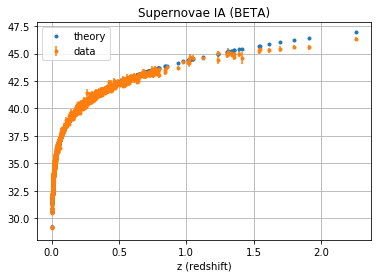

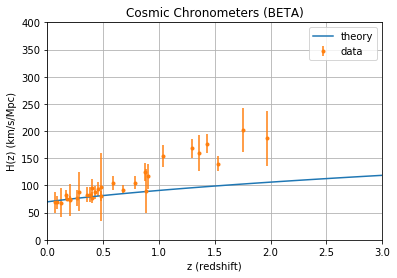

In [8]:
physical_params = [L_bar_val, beta, H0_val, r, s]

z_final, Hs_final = integrator_GILA(physical_params, model=model, num_z_points=int(len(z)),
                                    initial_z=z[0], final_z=z[-1])

Hs_interpolado = interp1d(z_final, Hs_final)
int_inv_Hs = cumtrapz(Hs_final**(-1), z_final, initial=0)
int_inv_Hs_interp = interp1d(z_final, int_inv_Hs)


zhd, zhel, mb, mu_shoes, Cinv, is_cal = ds_SN_plus_shoes #Import the data
muobs = mb - Mabs_val
muth_num = aparent_magnitude_th(int_inv_Hs_interp, zhd, zhel) #Numeric prediction of mu
muth = muth_num*(-is_cal + 1) + mu_shoes*(is_cal) #Merge num predicion with mu_shoes
emu=np.sqrt(np.diag(np.linalg.inv(Cinv)))
plt.figure()
plt.grid()
plt.title('Supernovae IA ({})'.format(model))
plt.plot(zhd,muth,'.',label='theory')
plt.errorbar(zhd,muobs,emu,fmt='.', label='data')
plt.legend()
plt.xlabel('z (redshift)')
#if close==True:
#    plt.close()



z_data, H_data, dH = ds_CC
H_interp = interp1d(z_final, Hs_final)
H_teo = H_interp(z_data)
plt.figure()
plt.grid()
plt.title('Cosmic Chronometers ({})'.format(model))
plt.plot(z_final,Hs_final,label='theory')
plt.errorbar(z_data,H_data,dH,fmt='.',label='data')
plt.legend()
plt.xlabel('z (redshift)')
plt.ylabel('H(z) (km/s/Mpc)')
plt.xlim(0, 3)
plt.ylim(0, 400)
#if close==True:
#    plt.close()